# Import Packages

In [15]:
import mysql.connector
from mysql.connector import errorcode
import config
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Load Data from MySQL

In [2]:
def connect(dbname):
    cnx = mysql.connector.connect(
        host = config.host,
        user = config.user,
        passwd = config.password,
        database = dbname,
        buffered = True
        )
    cursor = cnx.cursor()
    return cnx, cursor

In [3]:
def close_cnx():
    cursor.close()
    cnx.close()

In [177]:
cnx, cursor = connect('colleges')
cursor.execute("""SELECT * FROM ipeds_dir INNER JOIN ipeds_inst_char USING (unitid) INNER JOIN ipeds_adm_enroll USING (unitid) INNER JOIN ipeds_ug_headcount USING (unitid) INNER JOIN sc_stud_char USING (unitid)""")
ipeds_data = cursor.fetchall()
ipeds_data_df = pd.DataFrame(ipeds_data)
field_names = [i[0] for i in cursor.description]
ipeds_data_df.columns = field_names
close_cnx()

In [178]:
ipeds_data_df.drop(['year', 'inst_status', 'currently_active_ipeds', 'degree_granting'], axis = 1, inplace = True)

In [179]:
ipeds_data_df = ipeds_data_df[ipeds_data_df['primarily_postsecondary'] == 1]
ipeds_data_df.drop('primarily_postsecondary', axis = 1, inplace = True)

In [180]:
ipeds_data_df.offering_undergrad.value_counts()

1    4064
Name: offering_undergrad, dtype: int64

In [181]:
description = pd.DataFrame(ipeds_data_df.describe())
description = pd.DataFrame(description.loc['std'])
description[description['std'] == 0]

,std
year_deleted,0.0
offering_undergrad,0.0


In [182]:
ipeds_data_df.drop(['offering_undergrad', 'year_deleted'], axis = 1, inplace = True)

In [183]:
ipeds_data_df.columns.values

array(['unitid', 'inst_name', 'state_abbr', 'region',
       'urban_centric_locale', 'open_public', 'title_iv_indicator',
       'postsec_public_active', 'postsec_public_active_title_iv',
       'inst_control', 'institution_level', 'inst_category', 'inst_size',
       'sector', 'hbcu', 'hospital', 'medical_degree', 'tribal_college',
       'land_grant', 'offering_highest_degree', 'offering_highest_level',
       'offering_grad', 'cc_basic_2015', 'cc_instruc_undergrad_2015',
       'cc_undergrad_2015', 'cc_enroll_2015', 'cc_size_setting_2015',
       'inst_affiliation', 'primary_public_control',
       'occupational_prog_offered', 'academic_prog_offered',
       'cont_prof_prog_offered', 'avocational_prog_offered',
       'remedial_prog_offered', 'secondary_prog_offered', 'assoc_offered',
       'bach_offered', 'postbac_cert_offered', 'masters_offered',
       'doctors_research_offered', 'doctors_professional_offered',
       'doctors_other_offered', 'enrolled_undergrad_fulltime',
     

# Exploratory Data Analysis

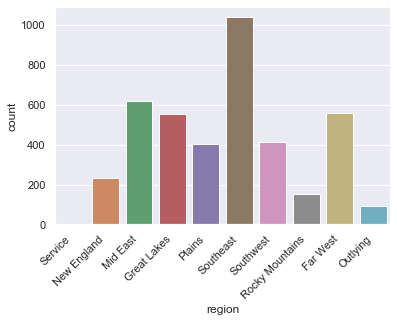

In [184]:
# Consider aggregating regions?
# Drop service schools
sns.set(style="darkgrid")
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'region', data = ipeds_data_df, ax = ax)
ax.set_xticklabels(['Service', 'New England', 'Mid East', 'Great Lakes', 'Plains', 'Southeast', 
                    'Southwest', 'Rocky Mountains', 'Far West', 'Outlying'], rotation = 45, 
                    horizontalalignment = 'right');

In [185]:
ipeds_data_df.region.value_counts()

5    1038
2     619
8     561
3     553
6     414
4     402
1     232
7     153
9      91
0       1
Name: region, dtype: int64

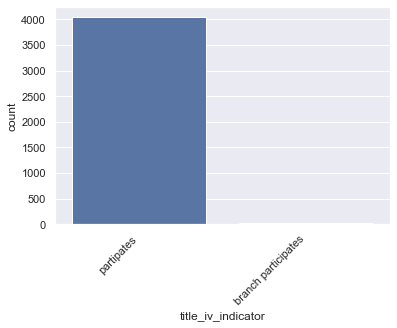

In [186]:
# Consider only keeping those that participate in title iv federal aid program
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'title_iv_indicator', data = ipeds_data_df, ax = ax)
ax.set_xticklabels(['partipates', 'branch participates', 'deferment only', 
                    'not participating,\n has OPE ID #', 'not participating,\n no OPE ID#'], 
                    rotation = 45, horizontalalignment = 'right');

In [187]:
ipeds_data_df.title_iv_indicator.value_counts()

1    4043
2      21
Name: title_iv_indicator, dtype: int64

1    4063
0       1
Name: open_public, dtype: int64

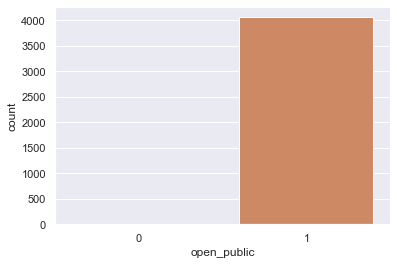

In [188]:
# Drop the one not open to public
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'open_public', data = ipeds_data_df, ax = ax)
# ax.set_xticklabels([], 
#                     rotation = 45, horizontalalignment = 'right');
ipeds_data_df.open_public.value_counts()

4    2566
2    1498
Name: institution_level, dtype: int64

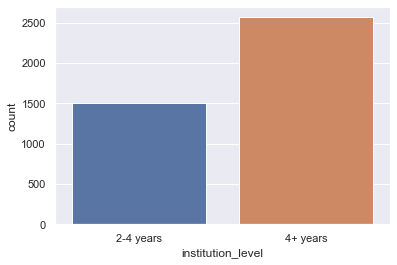

In [189]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'institution_level', data = ipeds_data_df, ax = ax)
ax.set_xticklabels(['2-4 years', '4+ years']);
ipeds_data_df.institution_level.value_counts()

1    1620
2    1467
3     977
Name: inst_control, dtype: int64

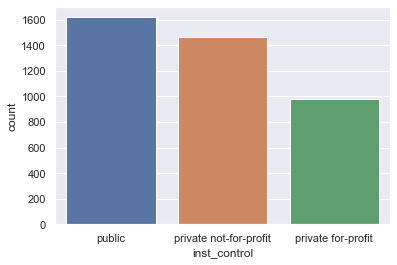

In [190]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'inst_control', data = ipeds_data_df, ax = ax)
ax.set_xticklabels(['public', 'private not-for-profit', 'private for-profit']);
ipeds_data_df.inst_control.value_counts()

2    2091
4    1499
3     465
1       9
Name: inst_category, dtype: int64

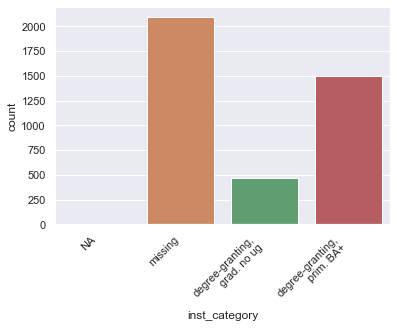

In [191]:
# Consider dropping degree-granting no ug (1), missing (-1), not applicable (-2)
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'inst_category', data = ipeds_data_df, ax = ax)
ax.set_xticklabels(['NA', 'missing', 'degree-granting,\n grad. no ug', 
                    'degree-granting,\n prim. BA+', 'degree-granting,\n prim. not BA+', 
                    'degree-granting,\n AA + cert.'], rotation = 45, 
                    horizontalalignment = 'right');
ipeds_data_df.inst_category.value_counts()

1    1544
2    1446
3     514
4     336
5     224
Name: inst_size, dtype: int64

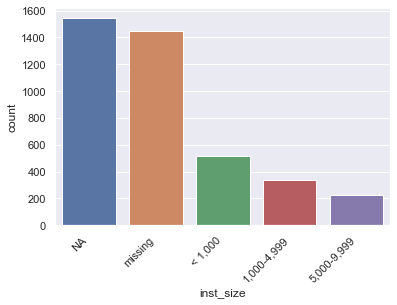

In [192]:
# Consider dropping NA (-2) and missing (-1)
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'inst_size', data = ipeds_data_df, ax = ax)
ax.set_xticklabels(['NA', 'missing', '< 1,000', '1,000-4,999', '5,000-9,999', 
                    '10,000-19,999', '20,000+'], rotation = 45, 
                    horizontalalignment = 'right');
ipeds_data_df.inst_size.value_counts()

2    1368
4     892
1     728
6     507
3     470
5      99
Name: sector, dtype: int64

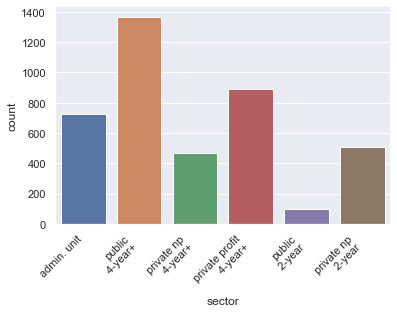

In [193]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'sector', data = ipeds_data_df, ax = ax)
ax.set_xticklabels(['admin. unit', 'public\n 4-year+', 'private np\n 4-year+', 
                    'private profit\n 4-year+', 'public\n 2-year', 'private np\n 2-year', 
                    'private profit\n 2-year'], rotation = 45, 
                    horizontalalignment = 'right');
ipeds_data_df.sector.value_counts()

In [194]:
adm_enroll_cols = [x for x in ipeds_data_df.columns if 'number' in x]
adm_enroll_df = ipeds_data_df[adm_enroll_cols]
adm_enroll_df.head()

,number_admitted_F,number_admitted_M,number_admitted_N,number_applied_F,number_applied_M,number_applied_N,number_enrolled_ft_F,number_enrolled_ft_M,number_enrolled_ft_N,number_enrolled_pt_F,number_enrolled_pt_M,number_enrolled_pt_N,number_enrolled_total_F,number_enrolled_total_M,number_enrolled_total_N
0,3878,2276,6154,4318,2725,7043,897,639,1536,19,13,32,916,652,1568
1,3437,2062,5499,5949,3510,9459,1218,730,1948,45,28,73,1263,758,2021
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1537,1930,3467,2160,2385,4545,472,731,1203,6,4,10,478,735,1213
4,2862,1293,4155,6086,2967,9053,724,428,1152,14,6,20,738,434,1172


In [195]:
adm_enroll_df_zeros = adm_enroll_df[adm_enroll_df['number_admitted_N'] == 0]
adm_enroll_df_nonzero = adm_enroll_df[adm_enroll_df['number_admitted_N'] > 0]

In [196]:
adm_enroll_df_zeros.shape

(2200, 15)

In [197]:
adm_enroll_df_nonzero.shape

(1864, 15)

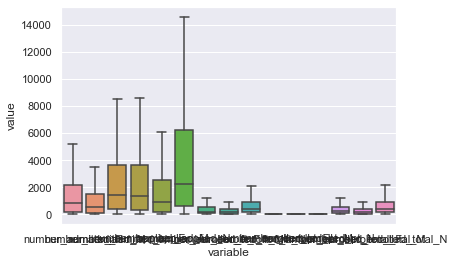

In [198]:
sns.boxplot(x="variable", y="value", data=pd.melt(adm_enroll_df_nonzero), showfliers = False)

# Basic Histograms

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


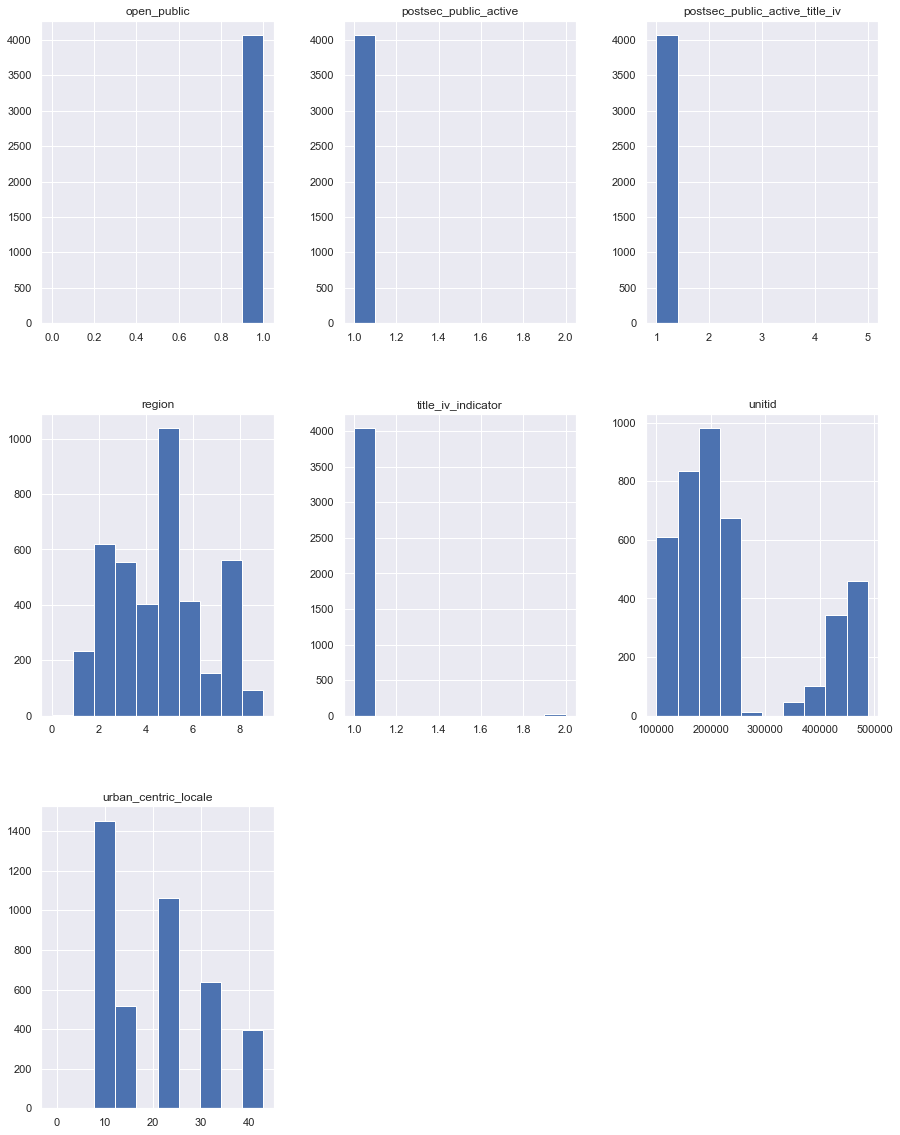

In [199]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
ipeds_data_df.iloc[:, 0:9].hist(ax = ax);

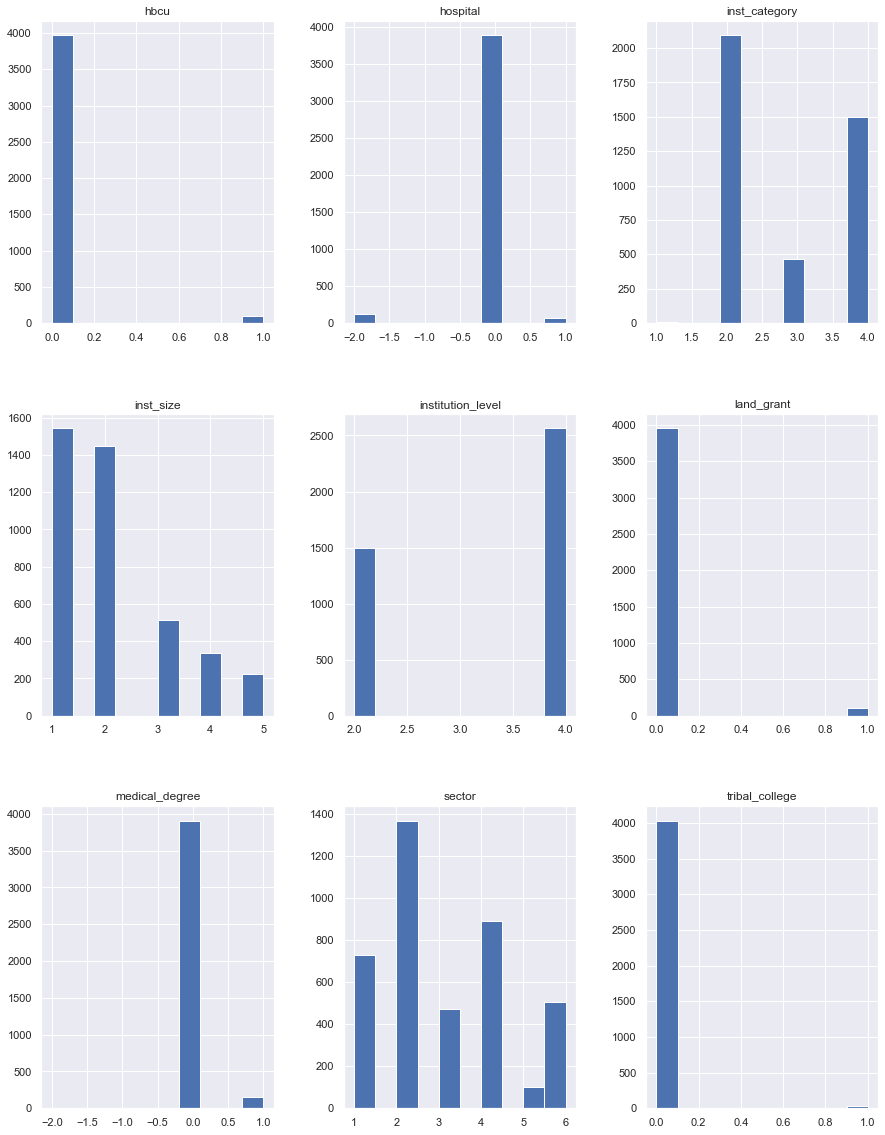

In [200]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
ipeds_data_df.iloc[:, 10:19].hist(ax = ax);

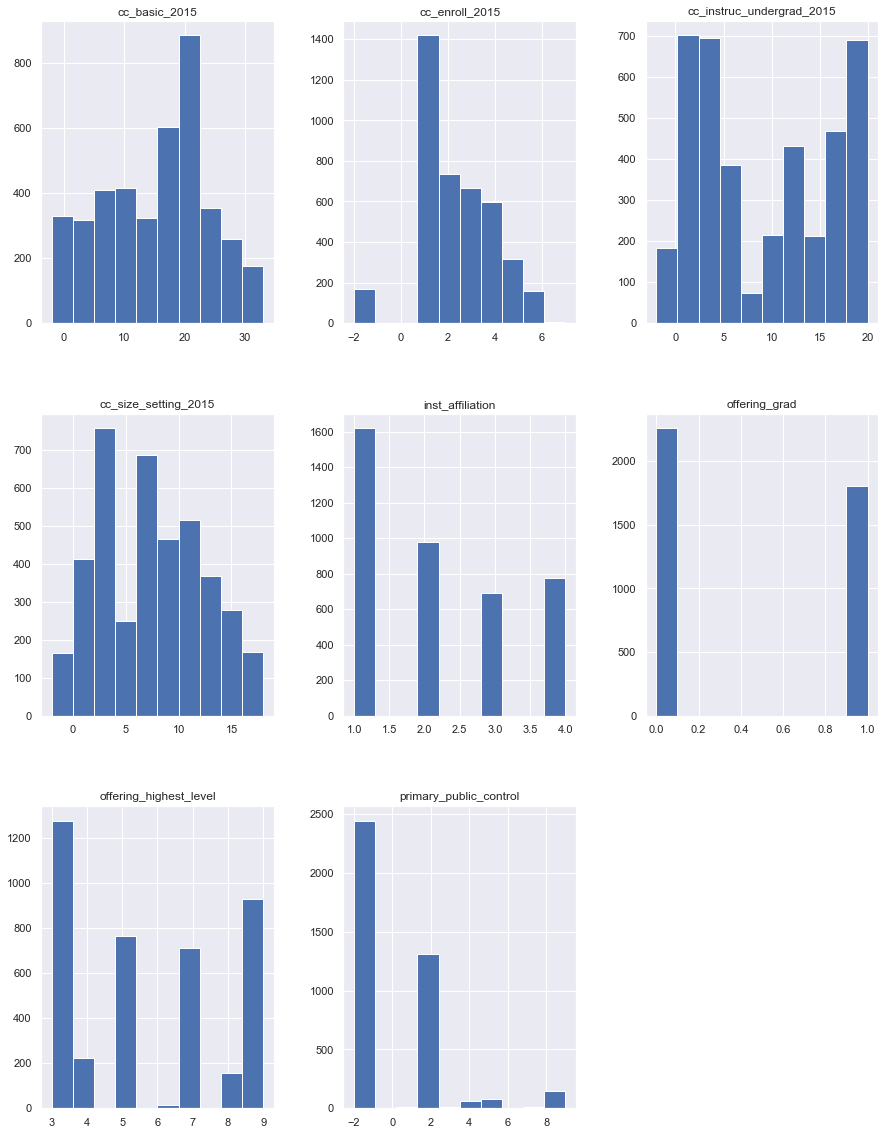

In [201]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
ipeds_data_df.iloc[:, 20:29].hist(ax = ax);

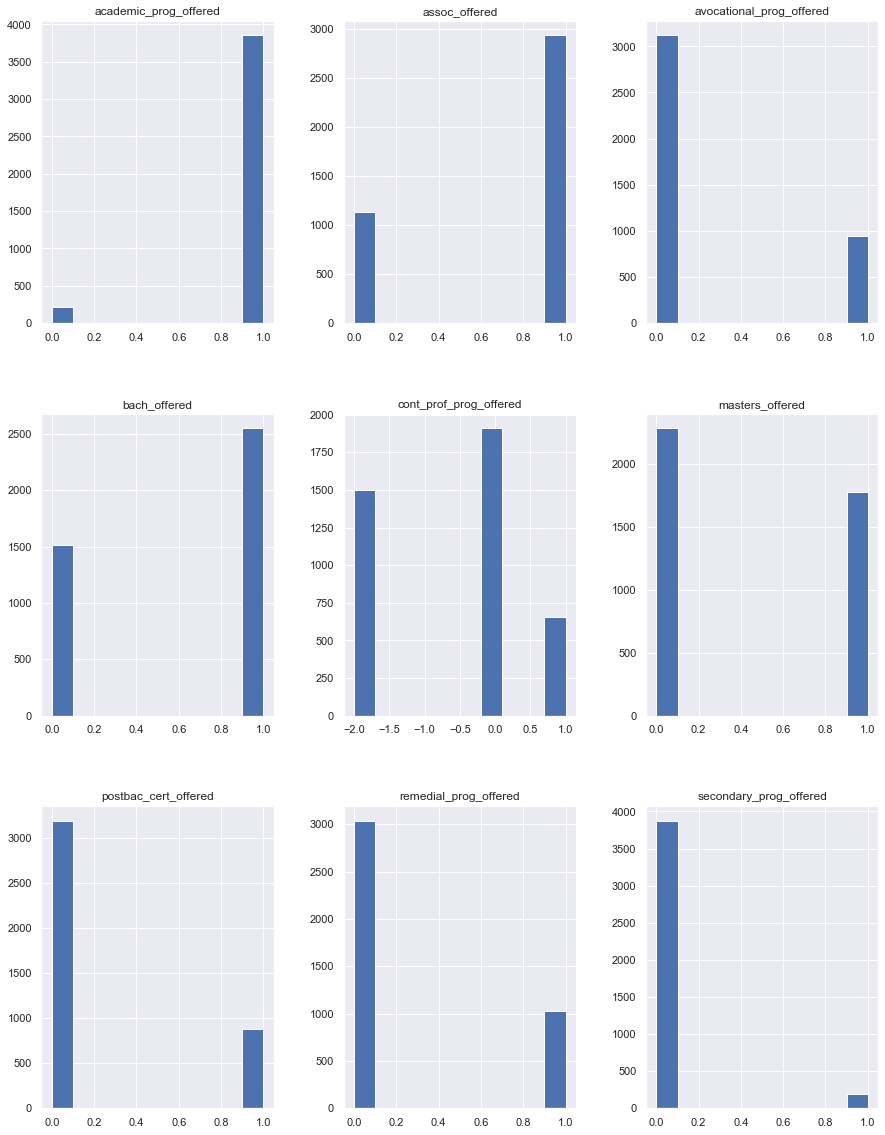

In [202]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
ipeds_data_df.iloc[:, 30:39].hist(ax = ax);

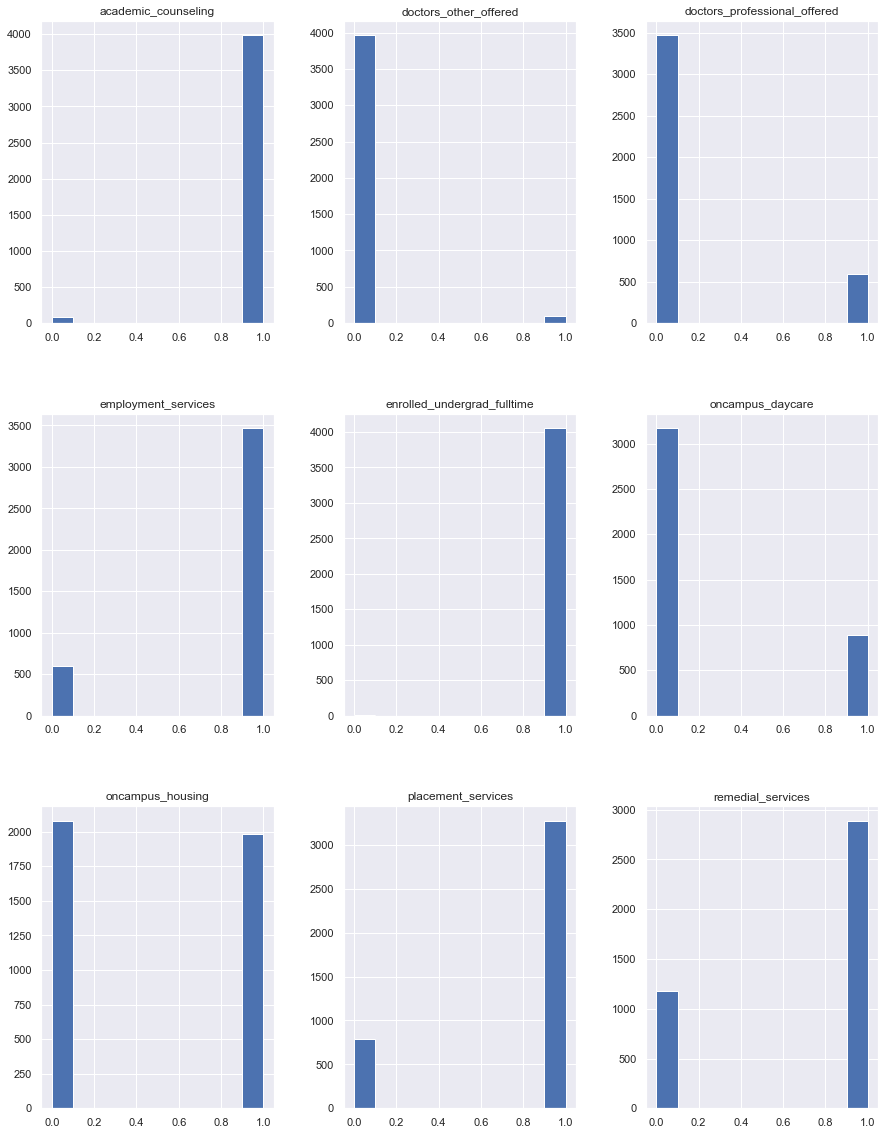

In [203]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
ipeds_data_df.iloc[:, 40:49].hist(ax = ax);

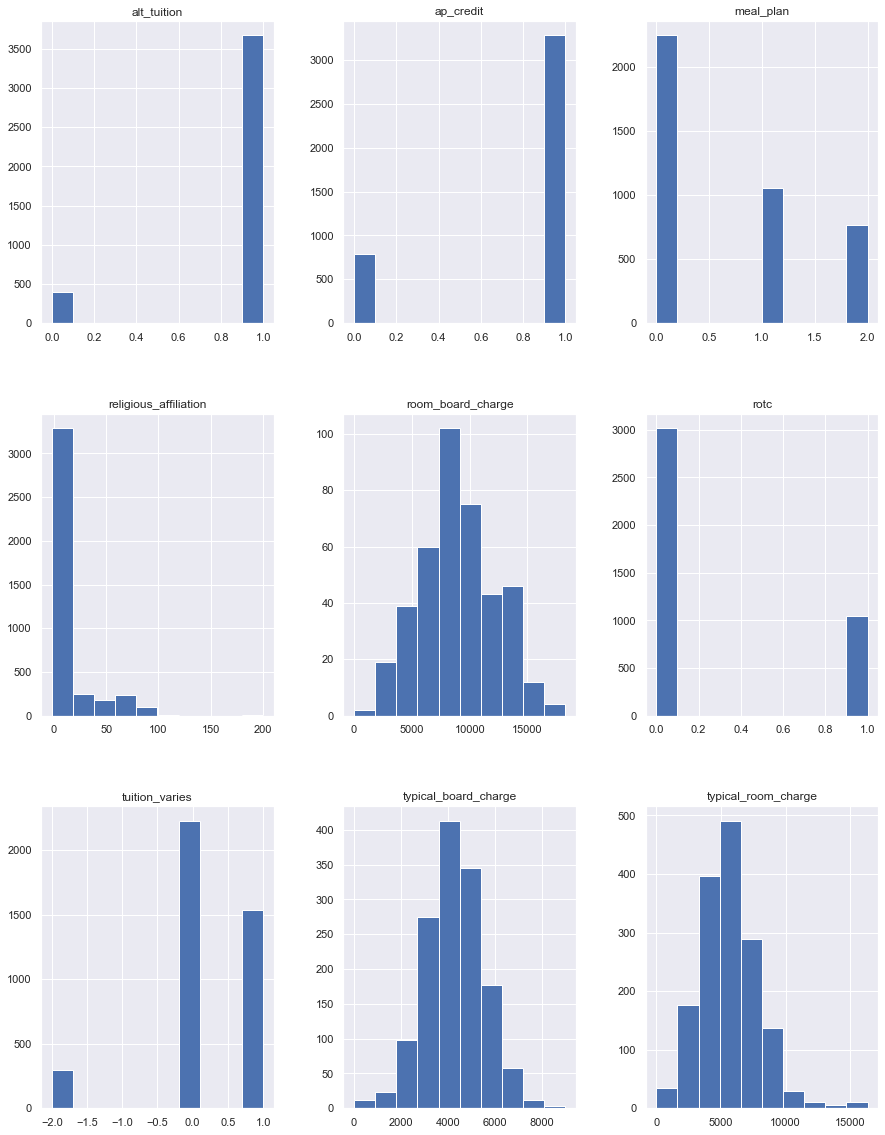

In [204]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
ipeds_data_df.iloc[:, 50:59].hist(ax = ax);

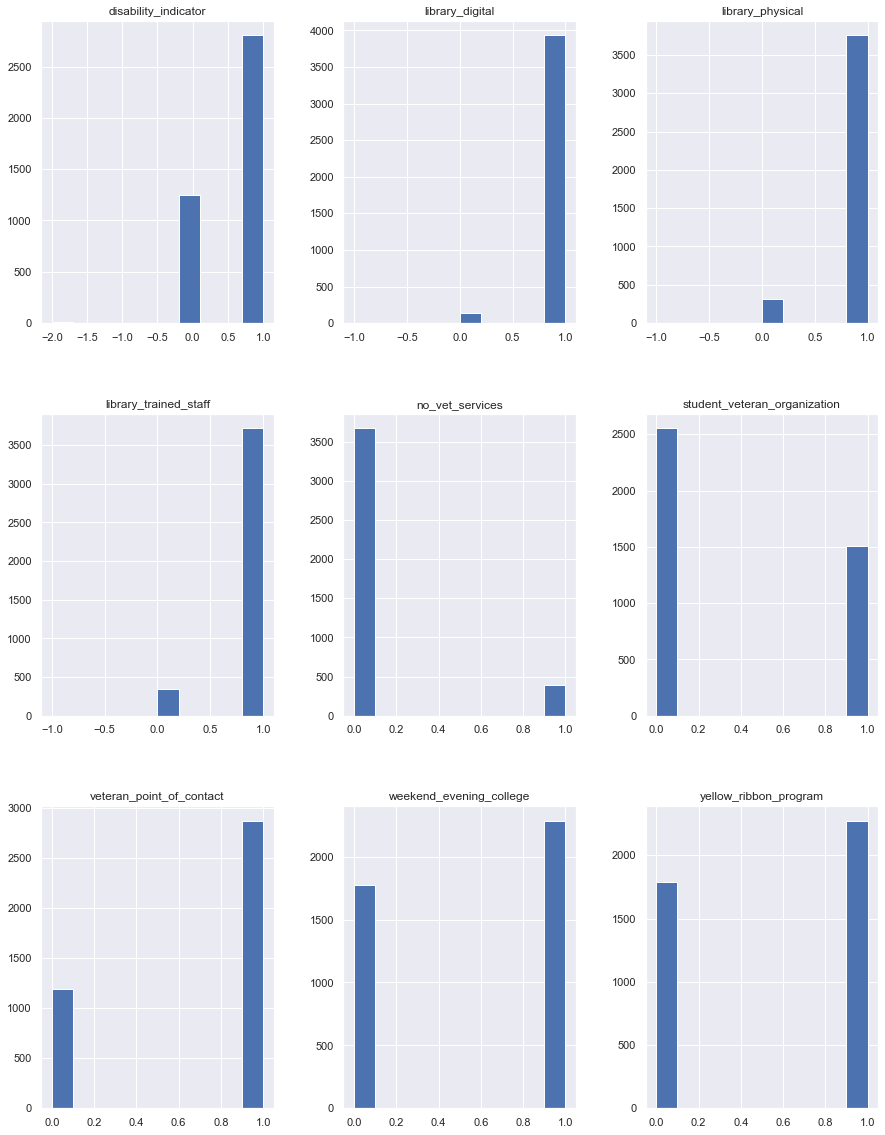

In [205]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
ipeds_data_df.iloc[:, 60:69].hist(ax = ax);

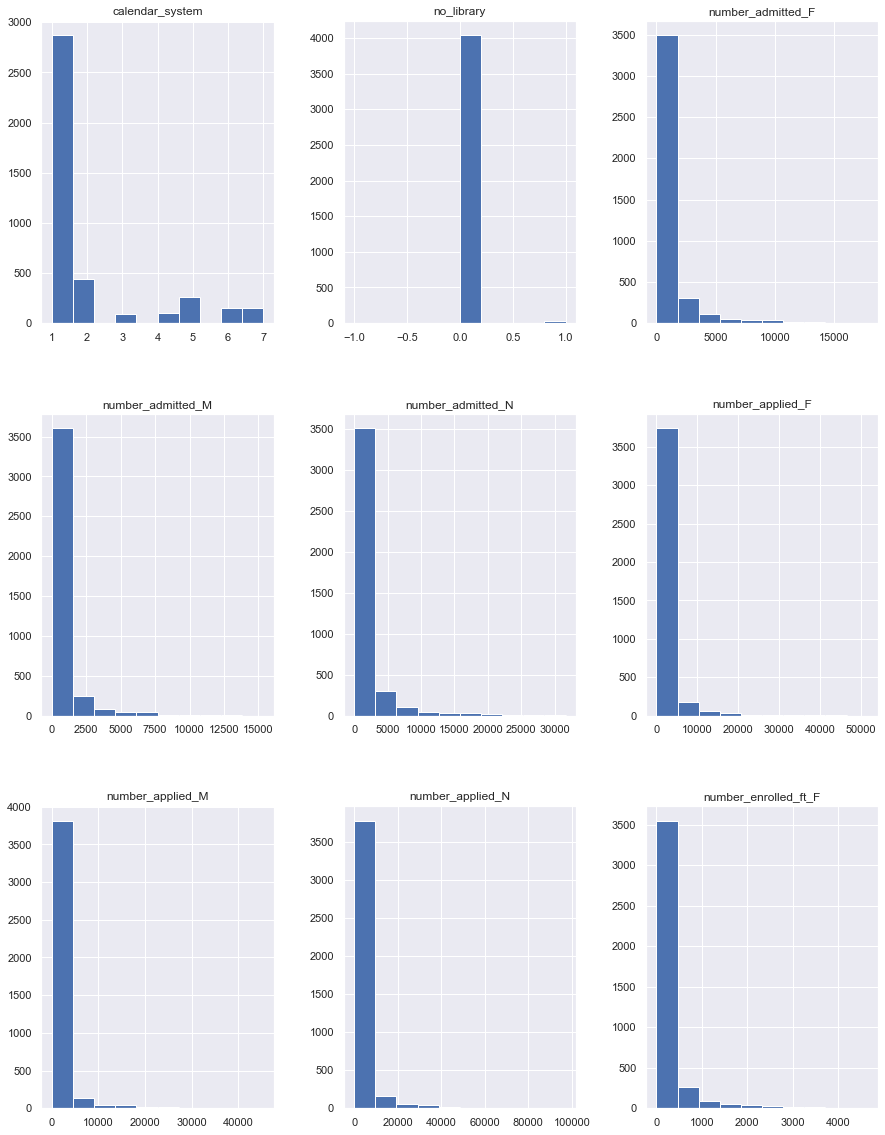

In [206]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
ipeds_data_df.iloc[:, 70:79].hist(ax = ax);

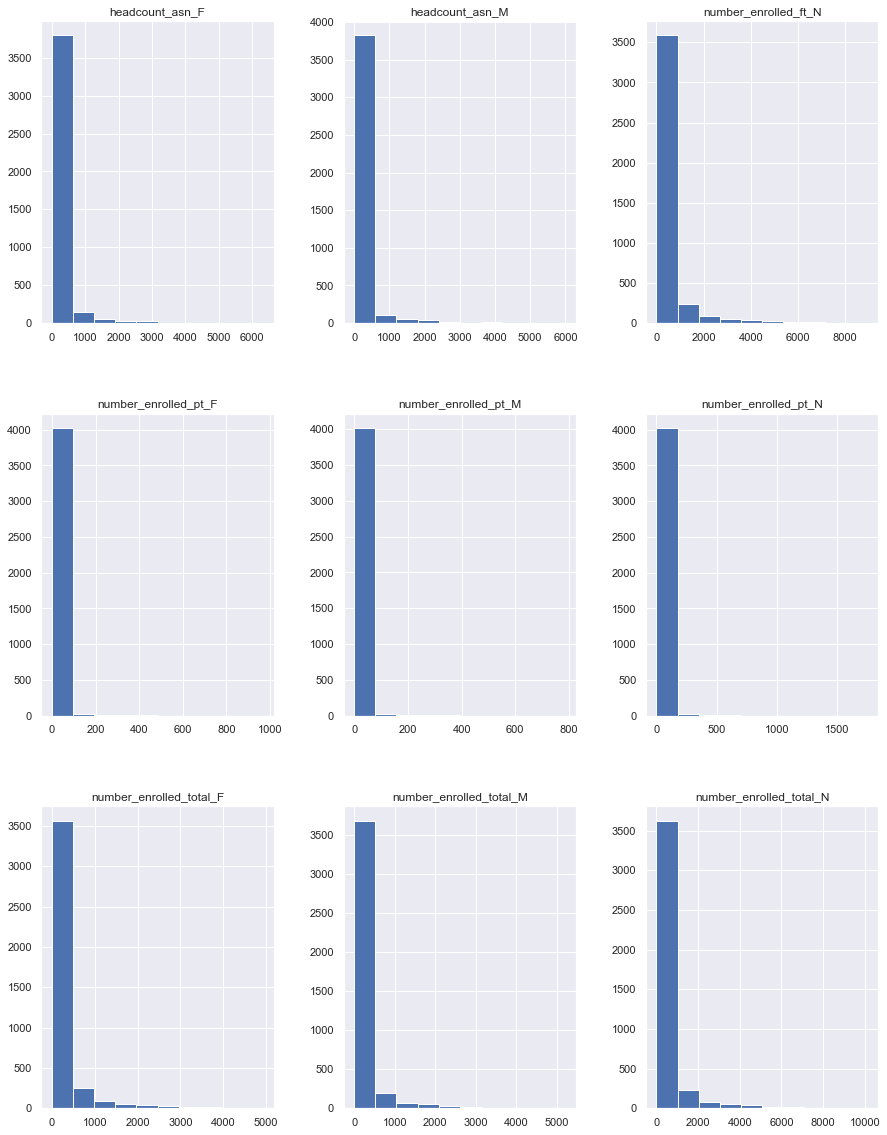

In [207]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
ipeds_data_df.iloc[:, 80:89].hist(ax = ax);

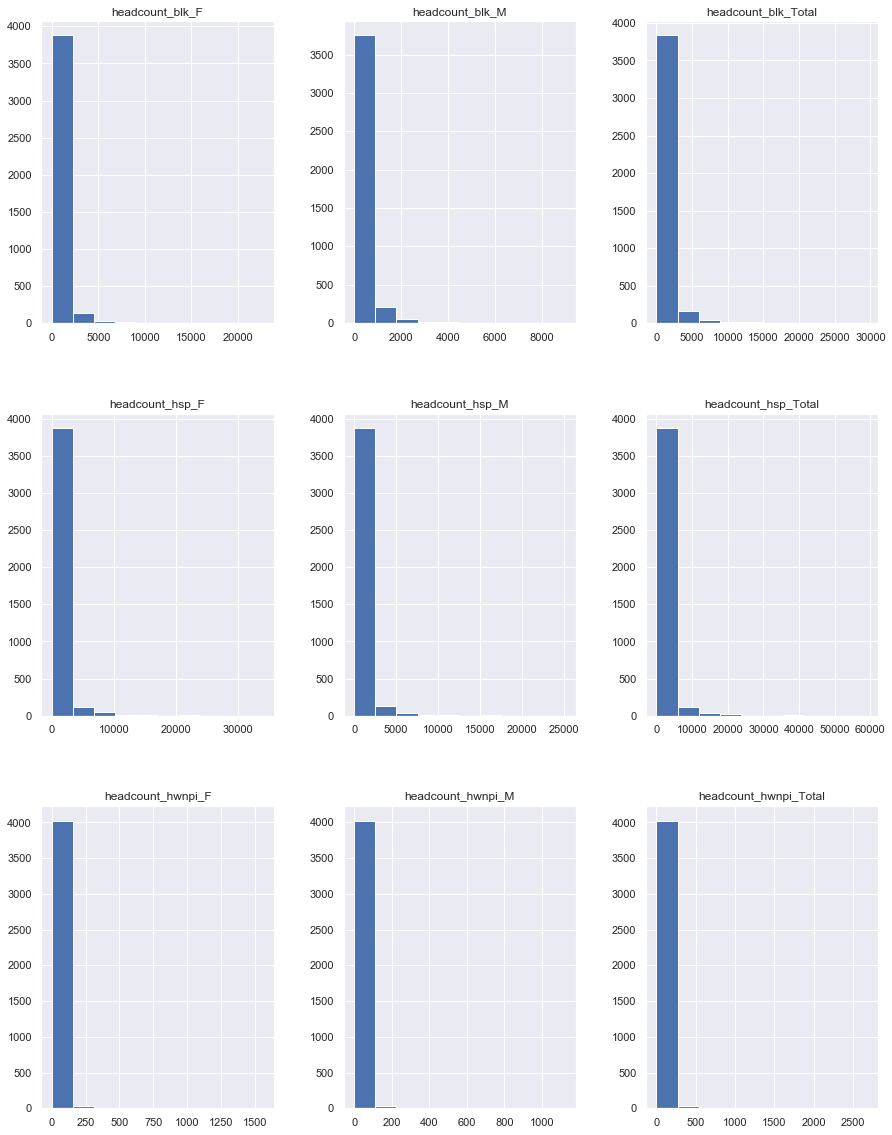

In [208]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
ipeds_data_df.iloc[:, 90:99].hist(ax = ax);

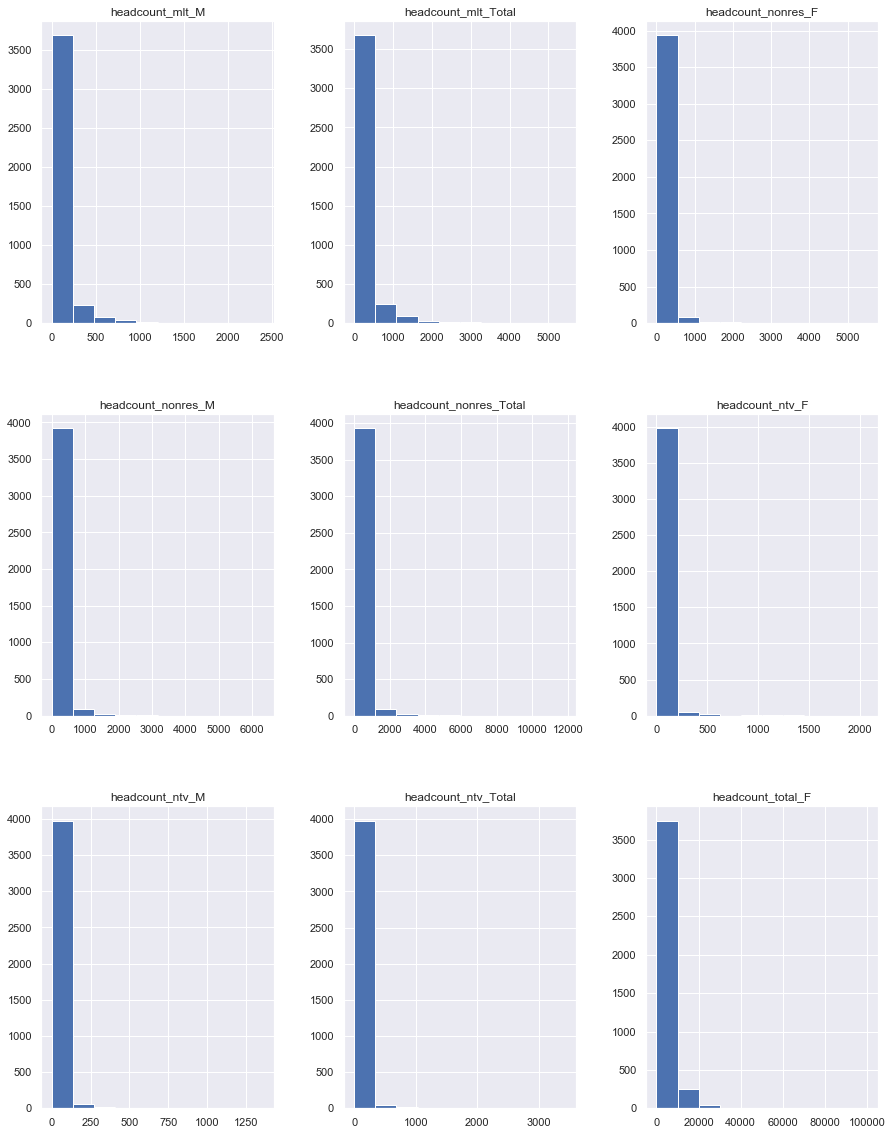

In [209]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
ipeds_data_df.iloc[:, 100:109].hist(ax = ax);

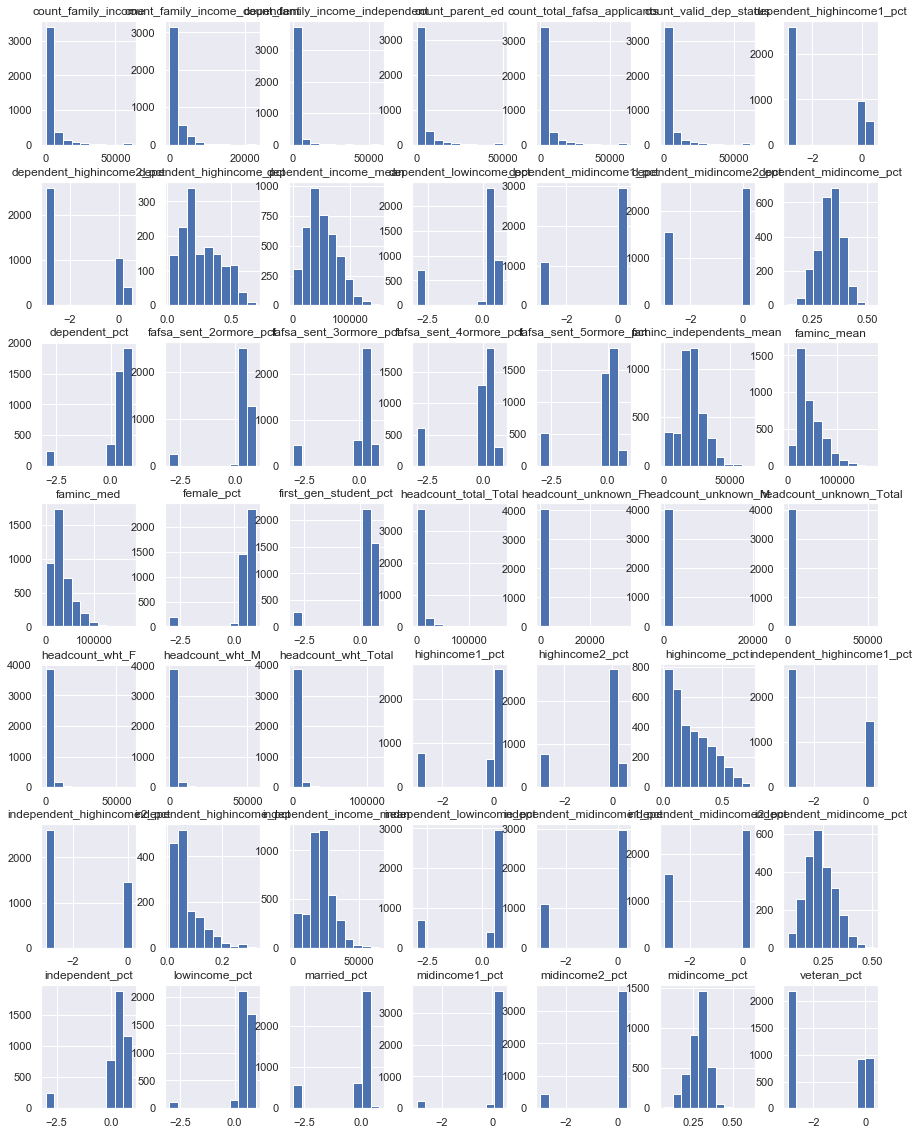

In [210]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
ipeds_data_df.iloc[:, 110:].hist(ax = ax);

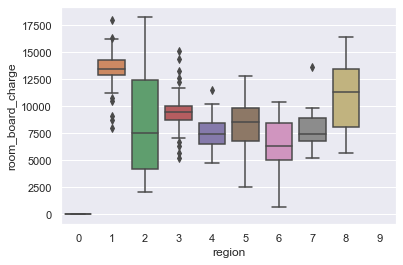

In [211]:
sns.boxplot(x = 'region', y = 'room_board_charge', data = ipeds_data_df)